In [2]:
using Pkg
Pkg.activate("..")
using Plots, PhasorNetworks, Random, DifferentialEquations

  Activating project at `~/code/PhasorNetworks.jl`


# Similarity

Continuing on from the previous notebooks, we'll now compute the similarity of an HD symbol to another HD symbol via two methods: one, a standard trig-based method, and the other, via the interference of waves! 

Let's pick back up where we were previously: computing the similarity of HD symbols (long vectors of phase values). Previously, we computed these values by taking the mean of the cosine distance between symbols:

In [3]:
prng_key = Xoshiro("ICONS2025")
n_phases = 1024

1024

In [4]:
symbol_a = random_symbols((n_phases, 1), prng_key)
symbol_b = random_symbols((n_phases, 1), prng_key);

And, as we saw, random symbols have a 99.9999....% (depending on the number of phase values) chance of being highly dissimilar:

In [5]:
similarity(symbol_a, symbol_b)

1-element Vector{Float32}:
 0.014428152

We began to explore the question of how you can manipulate symbols to make them more or less similar to one another in the previous notebook (01). Now, let's explore this a bit further.

As you determined in the previous notebook, to make a symbol which is *exactly* dissimilar to another, you can take the first and "rotate" each of its angles by $\pi / 2$ ($0.5$ normalized radians). This makes each angle exactly orthogonal to the other (or, at least as close to perfectly orthogonal we can get while using floating-point numbers).

In [6]:
symbol_a_not = symbol_a .+ 0.5;

In [7]:
similarity(symbol_a, symbol_a_not)

1-element Vector{Float64}:
 -4.371139000186249e-8

In fact, we can create a whole series of symbols with a varying degree of similarity to *a* by simply adding normalized angles between $0$ and $0.5$:

In [66]:
rotations = range(0.0, 0.5, length=21)
symbol_a_family = [symbol_a .+ angle for angle in rotations] |> stack
similarity_family = similarity(symbol_a, symbol_a_family);

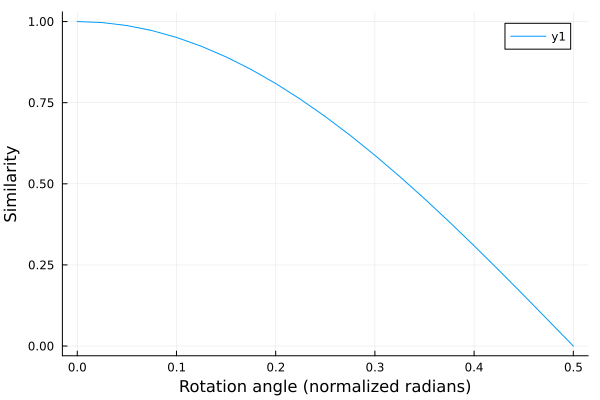

In [65]:
plot(rotations, similarity_family')
xlabel!("Rotation angle (normalized radians)")
ylabel!("Similarity")

Quick exercise: what happens if we go past an offset of 0.5? Does a pattern emerge? How far does it take for this pattern to repeat?

In [ ]:
rotations = range(0.0, ?, length=21)
symbol_a_family = [symbol_a .+ angle for angle in rotations] |> stack;

In [ ]:
plot(rotations, similarity(symbol_a, symbol_a_family)')
xlabel!("Rotation angle (normalized radians)")
ylabel!("Similarity")

Now that we've explored an experiment which allows us to calculate a variety of similarity ranges, rather than just 0, 1, or -1, we can explore how well we can replicate these calculations using a secondary method: the interference of waves (notebook 02). 

Rather than manually defining the differential equations this time, we'll take advantage of the code which already exists in PhasorNetworks.jl to carry out this experiment. Because we have limited time, we'll be skipping over some of the "behind the scenes" magic which is going on here and summarize it briefly as we apply it!

* SpikingArgs determines a lot of parameters (leakage, resonant frequency, solver arguments, etc) and stores them conveniently in a structure we can pass from function to function.

In [21]:
spk_args = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


* Previously, we defined a current function which drove individual current inputs to resonate-and-fire neurons. Here, we'll use this function to automatically convert our symbols into spike trains. Each spike train contains a series of times and indices - these cause currents to arise in each neuron at an appropriate time, causing it to resonate with the correct phase value relative to its group!

In [47]:
input_spikes_a = phase_to_train(symbol_a[:,:,1:1], spk_args=spk_args, repeats=6)

Spike Train: (1024, 1, 1) with 6144 spikes.

In [23]:
input_spikes_a_family = phase_to_train(symbol_a_family, spk_args=spk_args, repeats=6)

Spike Train: (1024, 1, 21) with 129024 spikes.

In [ ]:
osc_similarity = similarity(input_spikes_a, input_spikes_a_family, tspan=(0.0, 6.0), spk_args=spk_args);
size(osc_similarity)

1×21×602 Array{Float32, 3}:
[:, :, 1] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0

[:, :, 2] =
 -0.808594  -0.821778  -0.836917  …  -0.899414  -0.899902  -0.901367

[:, :, 3] =
 -0.800781  -0.80518  -0.817397  -0.835962  …  -0.893066  -0.89209  -0.89502

;;; … 

[:, :, 600] =
 1.0  0.996912  0.987674  0.97236  …  0.156334  0.0783222  -9.43052f-5

[:, :, 601] =
 1.0  0.996913  0.987675  0.972363  …  0.156349  0.0783354  -8.82855f-5

[:, :, 602] =
 1.0  0.996913  0.987675  0.972363  …  0.156349  0.0783354  -8.82889f-5

As you can see, we end up with a 1 x 21 x 602 matrix. This is because we now have similarity values calculated at multiple points in time - each point of the wave we've simulated!

Let's look at how the similarity values evolve over time:

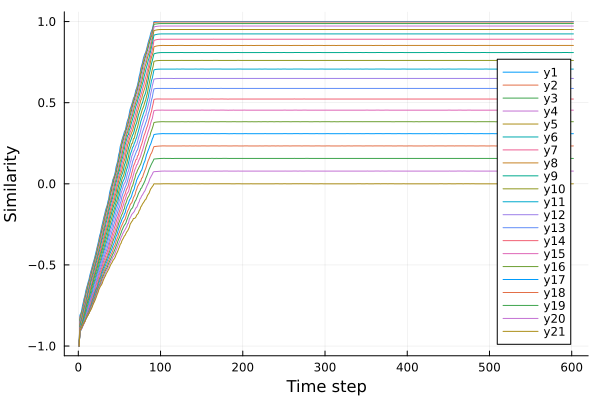

In [57]:
plot(osc_similarity[1,:,:]')
xlabel!("Time step")
ylabel!("Similarity")

As the oscillators integrate the input spikes, resonate with them, and reach a steady-state phase, the interference of their outputs converges to levels which are transformed into the similarity values we observe here! How closely do they match those we calculated with the "atemporal" trig versions? Pretty closely!

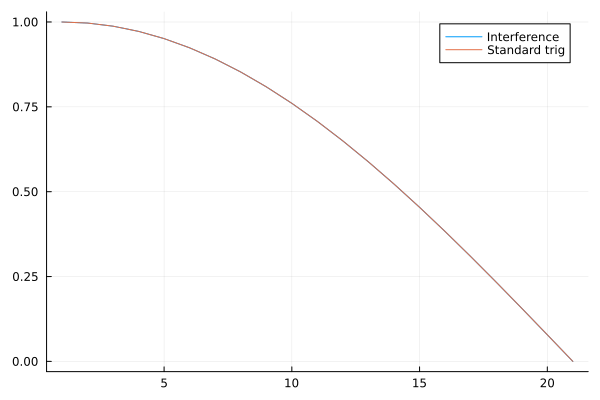

In [68]:
plot(osc_similarity[1,:,end], label="Interference")
plot!(similarity_family', label="Standard trig")

We actually can't see the two lines because they overlap too closely. Instead, let's compare the differences between the two:

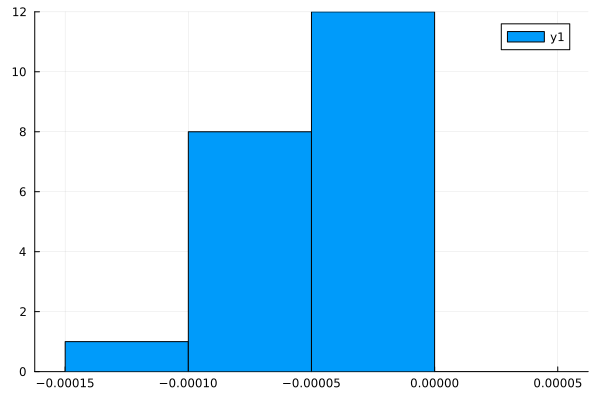

In [71]:
histogram(vec(osc_similarity[1,:,end] .- similarity_family[1,:]))

In [ ]:
# todo - setup a symbol and codebook with varying levels of similarity.
# sneakily introduce binding
# convert these phases to pulses in time!
# execute the differential equations
# compare results
# exercises: error through time
#  what affects levels of error?
#  how can you make results better / worse?
# what if we can selectively control how different phases interfere?
# (superposition)
# now we have superposition, bundling, binding...
# go to final demo notebook for neural network